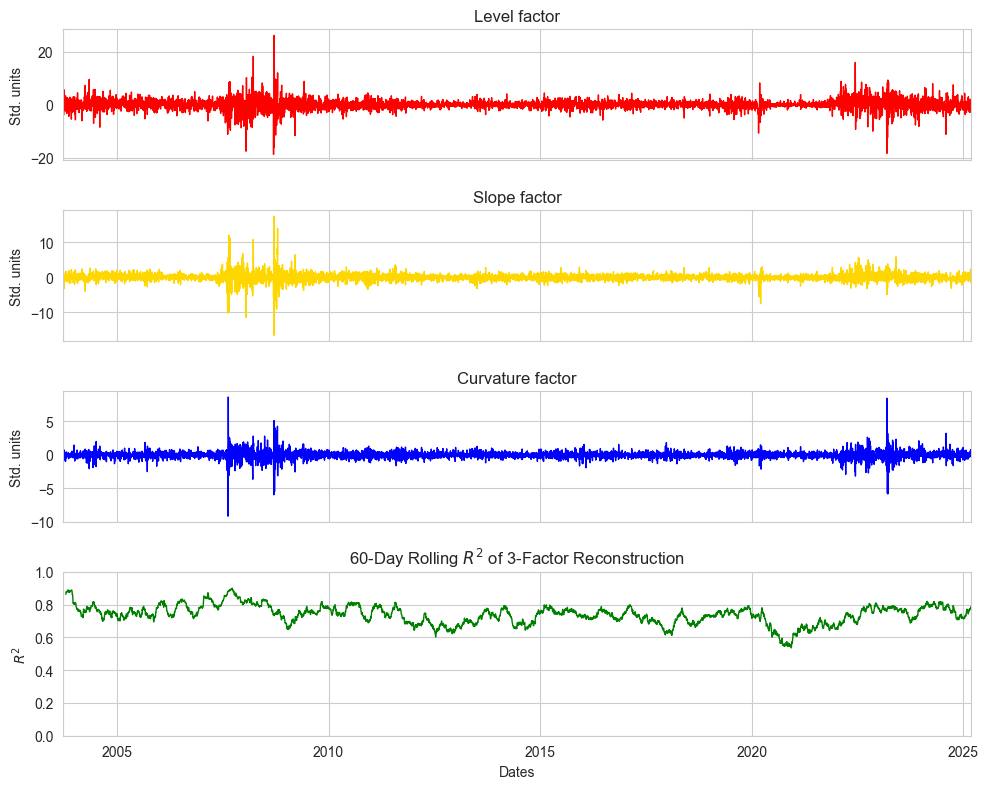

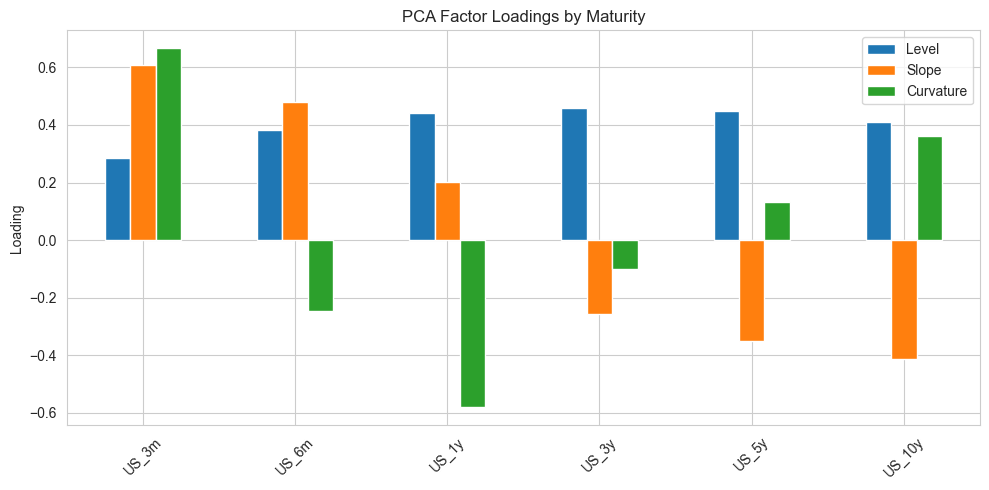

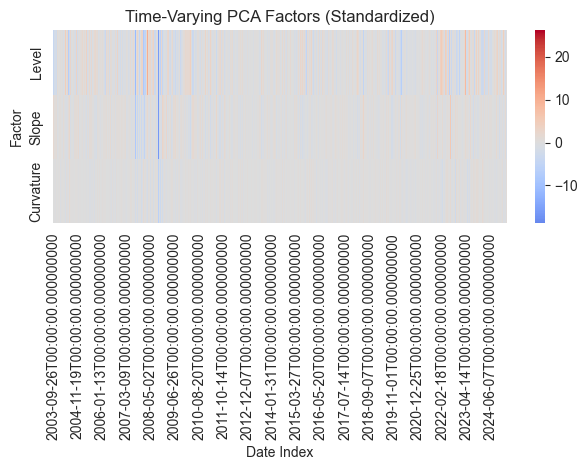


=== PCA Explained Variance ===
|           |   Explained Variance Ratio |
|:----------|---------------------------:|
| Level     |                     66.80% |
| Slope     |                     22.63% |
| Curvature |                      5.94% |

Average $R^2$ across all dates: 73.85%


In [2]:
#!/usr/bin/env python
"""
3-factor PCA of a Treasury yield curve panel.

Y_df.csv  ── CSV with an ISO-date index and one column per maturity
            (e.g. '1M','3M','6M','1Y',...,'30Y').
"""

# ---------- PARAMETERS ----------------------------------------------------
DATA_PATH = r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Y_df.csv"
PCA_ON    = "changes"      # "changes"  ➔ Δyields  (recommended)
N_COMPS   = 3              # number of principal components to keep
ROLL_WIN  = 60             # rolling window for R² plot
# --------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1 ▸ LOAD THE PANEL -------------------------------------------------------
Y = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True).sort_index()
Y = Y.dropna(how="all")  # drop rows that are entirely NaN

# 2 ▸ WORK WITH LEVELS OR DAILY CHANGES -----------------------------------
if PCA_ON.lower() == "changes":
    X = Y.diff().dropna()  # Δy_t := y_t − y_{t-1}
else:
    X = Y.copy()

# 3 ▸ STANDARDISE ----------------------------------------------------------
scaler = StandardScaler()
X_std  = scaler.fit_transform(X)

# 4 ▸ RUN PCA -------------------------------------------------------------
pca = PCA(n_components=N_COMPS)
scores = pca.fit_transform(X_std)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=["Level", "Slope", "Curvature"]
)

# Flip signs so level factor is mostly positive
if loadings["Level"].sum() < 0:
    scores  *= -1
    loadings *= -1

# 5 ▸ RESULTS PACKAGING ---------------------------------------------------
factors = pd.DataFrame(scores, index=X.index,
                       columns=["Level", "Slope", "Curvature"])
expl_var = pd.Series(pca.explained_variance_ratio_,
                     index=["Level", "Slope", "Curvature"],
                     name="Explained Variance Ratio")

# 6 ▸ RECONSTRUCT AND COMPUTE R² -----------------------------------------
X_hat_std = pca.inverse_transform(scores)
X_hat     = scaler.inverse_transform(X_hat_std)

# Compute element-wise reconstruction error
sse = ((X.values - X_hat)**2).sum(axis=1)

# Stability fix: avoid division by near-zero total variance
sst = ((X.values - X.values.mean(axis=1, keepdims=True))**2).sum(axis=1)
sst = np.where(sst < 1e-8, np.nan, sst)  # if sst too small, mark as NaN

r2_series = pd.Series(1 - sse / sst, index=X.index, name="R²")


# 7 ▸ FIXED ROLLING R² (TRADING DAYS ONLY) -------------------------------
roll_r2 = (
    r2_series
    .dropna()
    .rolling(window=ROLL_WIN, min_periods=15)
    .mean()
)

# 8 ▸ MAIN PLOT: FACTORS + R² (4 stacked subplots) with COLORS ------------
fig, ax = plt.subplots(
    4, 1, figsize=(10, 8), sharex=True,
    gridspec_kw={'height_ratios': [1, 1, 1, 1.25]}  # Give R² twice the height
)

# Custom color mapping
colors = {
    "Level": "red",
    "Slope": "gold",
    "Curvature": "blue"
}

# Plot Level, Slope, Curvature with less vertical space
for i, factor in enumerate(["Level", "Slope", "Curvature"]):
    factors[factor].plot(ax=ax[i], lw=1, color=colors[factor])
    ax[i].set_title(f"{factor} factor")
    ax[i].set_ylabel("Std. units")
    ax[i].grid(True)

# Plot R² with more vertical room
roll_r2.plot(ax=ax[3], lw=1, color='green')
ax[3].set_title(f"{ROLL_WIN}-Day Rolling $R^2$ of 3-Factor Reconstruction")
ax[3].set_ylabel("$R^2$")
ax[3].set_ylim(0, 1)
ax[3].grid(True)

fig.tight_layout()
plt.show()

# 9 ▸ LOADINGS BAR CHART --------------------------------------------------
loadings.plot(kind='bar', figsize=(10, 5))
plt.title("PCA Factor Loadings by Maturity")
plt.ylabel("Loading")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 10 ▸ HEATMAP OF FACTOR REALIZATIONS -------------------------------------
sns.heatmap(factors.T, cmap='coolwarm', center=0, cbar=True,
            xticklabels=300, yticklabels=True)
plt.title("Time-Varying PCA Factors (Standardized)")
plt.xlabel("Date Index")
plt.ylabel("Factor")
plt.tight_layout()
plt.show()

# 11 ▸ PRINT SUMMARY ------------------------------------------------------
print("\n=== PCA Explained Variance ===")
print(expl_var.to_markdown(floatfmt=".2%"))
print("\nAverage $R^2$ across all dates:", f"{r2_series.mean():.2%}")


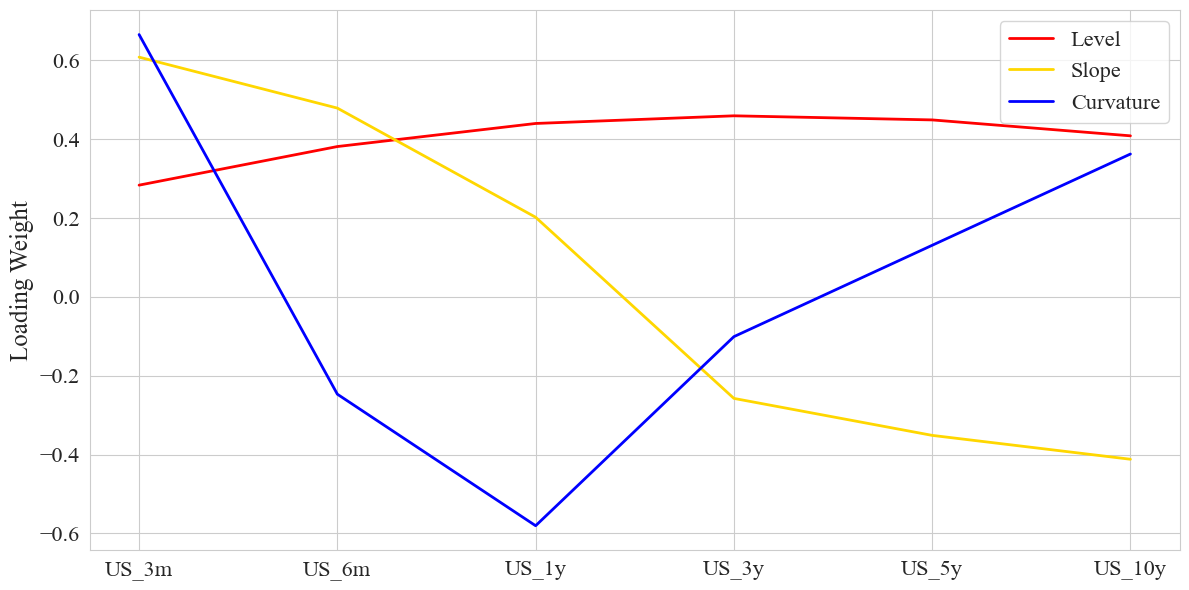

In [26]:
# ------------------ Maturity Sorting Function -------------------------
def maturity_to_months(label):
    label = label.upper().strip()
    if 'M' in label:
        return int(label.replace('M', '').replace('US_', ''))
    elif 'Y' in label:
        return int(label.replace('Y', '').replace('US_', '')) * 12
    else:
        return np.inf  # place unrecognized at end


# Use Times New Roman
plt.rcParams['font.family']    = 'serif'
plt.rcParams['font.serif']     = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'

# Sort maturities numerically
sorted_maturities = sorted(loadings.index, key=maturity_to_months)

# ------------------ Loadings Plot: Sorted by Maturity -----------------
plt.figure(figsize=(12, 6))
for factor, color in zip(["Level", "Slope", "Curvature"], ["red", "gold", "blue"]):
    plt.plot(sorted_maturities, loadings.loc[sorted_maturities, factor],
             label=factor, color=color, lw=2)

plt.ylabel("Loading Weight", fontsize= 18)
plt.xticks(rotation=0, fontsize = 16)
plt.yticks(rotation=0, fontsize = 16)
plt.grid(True)
plt.legend(fontsize= 16)
plt.tight_layout()
plt.show()
